In [3]:
import numpy as np
import pandas as pd
idx = pd.IndexSlice
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from itertools import product

import sys
sys.path.append('../funcs')
from taus import decorrelation_temporal_model, fit_coh_decay_model

from scipy.stats import linregress

In [2]:
df = pd.read_csv(Path('/Users/rdcrlzh1/Documents/uavsar-coherence/data/snotel').joinpath('snotel_uavsar_diffs.csv'))

In [ ]:
sns.scatterplot( "total_bill", "tip")

Slope: -0.003560718228873549. p: 5.175002404775814e-07


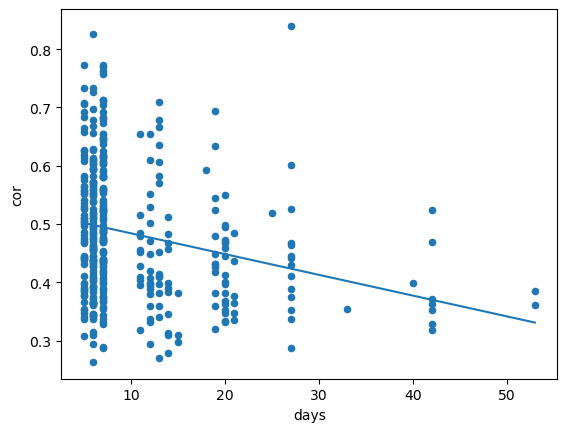

In [19]:
x_col = 'days'
sub = df[df.days < 100].dropna(subset = ['cor', x_col])

sub.plot.scatter(x = x_col, y = 'cor')

lm = linregress(x = sub[x_col], y = sub.cor)
xs = np.linspace(sub[x_col].min(), sub[x_col].max(), 100)
plt.plot(xs, lm.slope*xs+lm.intercept)
print(f'Slope: {lm.slope}. p: {lm.pvalue}')

<Axes: xlabel='tree_perc', ylabel='cor'>

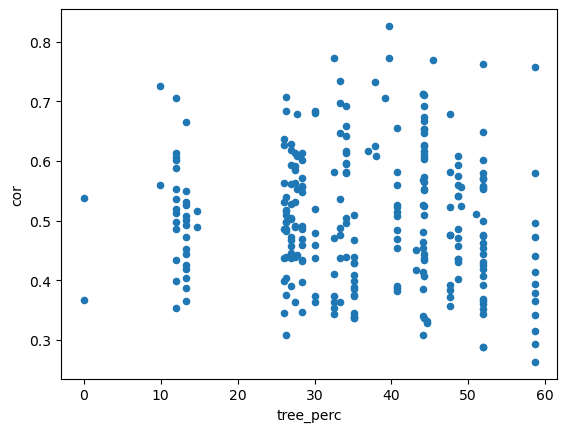

In [13]:
df[df.days < 8].plot.scatter(x = 'tree_perc', y = 'cor')